# State-space model

In [1]:
# generate data

import numpy as np

np.random.seed(0)
n, sigma, kappa, alpha = 100, 0.1, 0.3, 0.5

x = [0]
for i in range(n):
    x.append(x[-1] + np.random.normal(0, sigma))

x = np.array(x[1:])
y = x + np.random.normal(0, kappa, n)

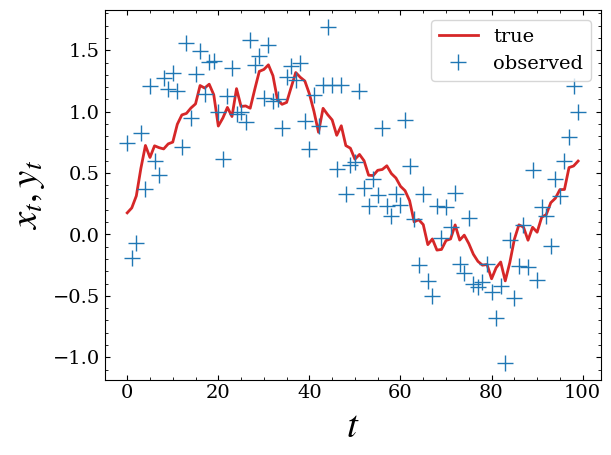

In [2]:
# data visualization

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

plt.plot(x, lw=2, color='tab:red', label='true')
plt.plot(y, '+', markersize=12, color='tab:blue', label='observed')
plt.xlabel('$t$', size=28)
plt.ylabel('$x_t, y_t$', size=28)
plt.legend()

In [3]:
# define a statistical model

import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.contrib.control_flow import scan

numpyro.set_host_device_count(4) # 4スレッドで並列計算

def model(x, y):
   x0 = numpyro.sample('x0', dist.Uniform(low=-100, high=100))
   alpha = numpyro.sample('alpha', dist.Uniform(low=-100, high=100))
   sigma = numpyro.sample('sigma', dist.Uniform(low=0, high=100))
   kappa = numpyro.sample('kappa', dist.Uniform(low=0, high=100))
   def transition(x, _):
      xt = numpyro.sample('xt', dist.Normal(x, sigma))
      return xt, xt
   _, xt = scan(transition, x0, jnp.arange(len(y)))
   numpyro.sample('y', dist.Normal(xt, kappa), obs=y)

In [4]:
# run MCMC

from jax import random
from numpyro.infer import MCMC, NUTS

rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples, num_chains = 1000, 2000, 4

kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc.run(rng_key_, x=x, y=y)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [5]:
# check the posterior distribution

mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      0.26     58.60      0.39    -90.35     90.17  11488.88      1.00
     kappa      0.29      0.03      0.29      0.25      0.34   3463.88      1.00
     sigma      0.15      0.03      0.15      0.10      0.20    671.51      1.00
        x0      0.42      0.24      0.42      0.04      0.84   6737.94      1.00
     xt[0]      0.42      0.18      0.42      0.12      0.72   6506.75      1.00
     xt[1]      0.32      0.17      0.32      0.03      0.60   3096.02      1.00
     xt[2]      0.37      0.16      0.37      0.10      0.63   3494.42      1.00
     xt[3]      0.53      0.15      0.53      0.29      0.77   6507.29      1.00
     xt[4]      0.61      0.15      0.61      0.37      0.85   7011.16      1.00
     xt[5]      0.75      0.15      0.75      0.49      0.97   6881.14      1.00
     xt[6]      0.76      0.15      0.77      0.53      1.01   7174.19      1.00
     xt[7]      0.83      0

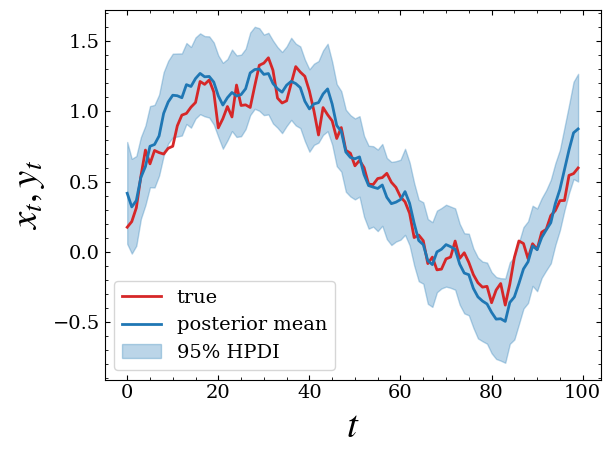

In [6]:
from numpyro.diagnostics import hpdi

mean_x = jnp.mean(mcmc.get_samples()['xt'], axis=0)
hpdi_x = hpdi(mcmc.get_samples()['xt'], 0.95)

idx = np.arange(len(y))

plt.plot(idx, x, lw=2, color='tab:red', label='true')
plt.plot(idx, mean_x, lw=2, color='tab:blue', label='posterior mean')
plt.fill_between(idx, hpdi_x[0], hpdi_x[1], alpha=0.3, color='tab:blue', label='95% HPDI')
plt.xlabel('$t$', size=28)
plt.ylabel('$x_t, y_t$', size=28)
plt.legend()